# LastFM Network Classification + EDA

Please see below the step-by-step process of building an ML model to predict the country that LastFM users originate from.

You may see some code missing relating to model selection. I have removed it for brevity, but there was a full process in place to select the best model out of the subset I considered which included Logistic Regression, Random Forest, GNNs, XGBoost and others. The model that got selected due to performance was LGBoost, which you will see being used and tuned in the code below.

# Context

"A social network of LastFM users which was collected from the public API in March 2020. Nodes are LastFM users from Asian countries and edges are mutual follower relationships between them. The vertex features are extracted based on the artists liked by the users. The task related to the graph is multinomial node classification - one has to predict the location of users. This target feature was derived from the country field for each user."

https://paperswithcode.com/dataset/lastfm-asia


**Table of Contents**
* [Section 1: Setup](#chapter1)
* [Section 2: EDA](#chapter2)
* [Section 3: Preprocessing - Test train splits](#chapter3)
* [Section 4: Preprocessing](#chapter4)
* [Section 5: Creating a Baseline Model](#chapter5)
* [Section 6: Model Building](#chapter6)
* [Section 7: Error/Performance Anaylsis ](#chapter7)
* [Section 8: Feature Selection (Custom backward stepwise algo)
](#chapter8)
* [Section 9: Final Model](#chapter9)


## Loading in Data

In [81]:
import os
import urllib.request
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random, os
import networkx as nx
import pandas as pd
import zipfile
import json
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from networkx.algorithms import community
import matplotlib.pyplot as plt
from collections import Counter
import regex as re
from sklearn.metrics import classification_report
import lightgbm as lgb
from lightgbm import LGBMClassifier
from itertools import product
from collections import defaultdict, Counter


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [83]:
print(os.path.abspath(os.getcwd()))
data = urllib.request.urlretrieve("https://snap.stanford.edu/data/lastfm_asia.zip", 'lastfmdata')

/content


In [84]:
with zipfile.ZipFile('lastfmdata', 'r') as zip_ref:
    zip_file_list = zip_ref.namelist()

for i, file_path in enumerate(zip_file_list):
    print(i, file_path)

0 lasftm_asia/
1 lasftm_asia/lastfm_asia_edges.csv
2 lasftm_asia/lastfm_asia_target.csv
3 lasftm_asia/lastfm_asia_features.json
4 lasftm_asia/README.txt


In [85]:
with zipfile.ZipFile('lastfmdata', 'r') as zip_ref:
    # List all the files in the zip
    zip_file_list = zip_ref.namelist()

    # Read the contents of each file
    for file_path in zip_file_list:

      if re.match(r".*lastfm_asia_features.*", file_path):
        # Open the file within the zip
        with zip_ref.open(file_path) as file:
            # Read the contents of the file
            json_data = json.load(file)
      elif re.match(r".*lastfm_asia_edges.*", file_path):
          with zip_ref.open(file_path) as file:
                # Read the CSV file with pandas
                graph_df = pd.read_csv(file)

      elif re.match(r".*lastfm_asia_target.*", file_path):
          with zip_ref.open(file_path) as file:
                # Read the CSV file with pandas
                target_df = pd.read_csv(file)

 ## Section 1. Setup  <a class="anchor" name = "chapter1" id="chapter1"></a>

In [76]:
# Create a new graph
graph = nx.Graph()

# Add nodes from the graph file
nodes = set(graph_df['node_1']).union(set(graph_df['node_2']))
graph.add_nodes_from(nodes)

# Add edges from the graph file
edges = graph_df[['node_1', 'node_2']].values
graph.add_edges_from(edges)

# Add target information to graph nodes
target_mapping = dict(target_df[['id', 'target']].values)
nx.set_node_attributes(graph, target_mapping, 'target')

G = graph
del graph

In [78]:
all_artists = set()
artist_counts = Counter()
# Iterate over the JSON data
for node_id, attributes in json_data.items():
    if int(node_id) in G.nodes:
        G.nodes[int(node_id)]["music"] = attributes
        all_artists.update(attributes)
        artist_counts.update(attributes)

In [79]:
assert len(G.edges) == 27806, "Not enough edges"
assert len(G.nodes) == 7624, "Not enough nodes"

In [80]:
node_data = [(node, G.nodes[node]) for node in G.nodes()]
node_df = pd.DataFrame(node_data, columns=['Node', 'Attributes'])

In [91]:
loaded_dfs = [target_df, node_df, graph_df]
for df in loaded_dfs:
  print(df.head())
  print(df.describe())
  print(df.info())

   id  target
0   0       8
1   1      17
2   2       3
3   3      17
4   4       5
                id       target
count  7624.000000  7624.000000
mean   3811.500000     9.339979
std    2201.003559     5.917230
min       0.000000     0.000000
25%    1905.750000     5.000000
50%    3811.500000    10.000000
75%    5717.250000    15.000000
max    7623.000000    17.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7624 entries, 0 to 7623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      7624 non-null   int64
 1   target  7624 non-null   int64
dtypes: int64(2)
memory usage: 119.2 KB
None
   Node                                         Attributes
0     0  {'target': 8, 'music': [2964, 3900, 3902, 2402...
1     1  {'target': 17, 'music': [7375, 1890, 2400, 112...
2     2  {'target': 3, 'music': [753, 873, 1545, 4857, ...
3     3  {'target': 17, 'music': [504, 3380, 4626, 1836...
4     4  {'target': 5, 'music': [6897, 689

## Section 2. EDA  <a class="anchor" name = "chapter2" id="chapter2"></a>

In [86]:
target_artist_counts = defaultdict(Counter)

for node_id, attributes in G.nodes(data=True):
    if 'target' in attributes:
        target = attributes['target']
        # If the target is available, update the count of artists for that target
        target_artist_counts[target].update(attributes.get("music", {}))

# Get the most common artists for each target
most_common_artists_by_target = {}
for target, artist_counter in target_artist_counts.items():
    most_common_artists_by_target[target] = artist_counter.most_common(3)  # Change 5 to get more or fewer top artists

data = [{'target': target, 'artist': artist, 'count': count}
        for target, artist_count in most_common_artists_by_target.items()
        for artist, count in artist_count]

df = pd.DataFrame(data)

sorted_df = df.sort_values(['target', 'count'], ascending=[True, False])
print(sorted_df)
# printing number of times that an artist is liked for each target (country)

    target  artist  count
15       0    4111    864
16       0    1409    784
17       0    4648    739
48       1    3237     37
49       1    2463     36
50       1    7014     34
30       2    4111     59
31       2    3237     49
32       2    1409     48
6        3    3237    355
7        3    4394    345
8        3    5242    330
42       4    7014     11
43       4    4830     11
44       4    3876     11
9        5    4111    257
10       5    6388    239
11       5    4648    234
12       6    4111    514
13       6    4648    466
14       6    4464    440
39       7    4111     48
40       7    7767     48
41       7    3237     48
0        8    4111    328
1        8    1409    303
2        8    7786    280
45       9    7767     42
46       9    2463     42
47       9    4111     42
21      10    4111   1033
22      10    7767   1018
23      10     416    934
33      11    4648    112
34      11    3876    109
35      11    7767    106
51      12    4111     48
52      12  

In [11]:
most_common_artists = artist_counts.most_common()
top_10 = most_common_artists[:10]

bottom_10 = most_common_artists[-10:]

print("Top 10 MOST common artists:")
for artist, count in top_10:
    print(f"{artist}: {count}")

print("\n 10 LEAST common artists:")
for artist, count in bottom_10:
    print(f"{artist}: {count}")

Top 10 MOST common artists:
4111: 5532
4648: 4777
3876: 4429
1409: 4398
4394: 4224
3237: 4181
3523: 4154
4893: 4055
4439: 3988
6388: 3901

 10 LEAST common artists:
6987: 101
7205: 101
6011: 101
4573: 101
4388: 101
1610: 101
3802: 101
2307: 101
4638: 101
6562: 101


<Axes: xlabel='target'>

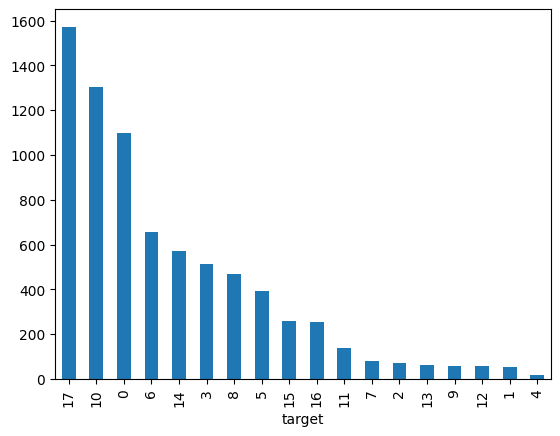

In [12]:
target_df['target'].value_counts().plot(kind = "bar")

In [13]:
degrees = dict(G.degree())


top_10_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes with the highest degrees:")
for node, degree in top_10_degrees:
    print("Node:", node, "Degree:", degree, "target(country):", G.nodes[node]['target'])

# Find the bottom 10 lowest degree nodes
bottom_10_degrees = sorted(degrees.items(), key=lambda x: x[1])[:10]

print("\nBottom 10 nodes with the lowest degrees:")
for node, degree in bottom_10_degrees:
    print("Node:", node, "Degree:", degree, "target(country):", G.nodes[node]['target'])

Top 10 nodes with the highest degrees:
Node: 7237 Degree: 216 target(country): 0
Node: 3530 Degree: 175 target(country): 17
Node: 4785 Degree: 174 target(country): 6
Node: 524 Degree: 172 target(country): 15
Node: 3450 Degree: 159 target(country): 17
Node: 2510 Degree: 140 target(country): 14
Node: 3597 Degree: 124 target(country): 0
Node: 2854 Degree: 119 target(country): 0
Node: 5127 Degree: 119 target(country): 17
Node: 6101 Degree: 119 target(country): 10

Bottom 10 nodes with the lowest degrees:
Node: 0 Degree: 1 target(country): 8
Node: 4 Degree: 1 target(country): 5
Node: 5 Degree: 1 target(country): 17
Node: 8 Degree: 1 target(country): 0
Node: 10 Degree: 1 target(country): 17
Node: 22 Degree: 1 target(country): 17
Node: 24 Degree: 1 target(country): 10
Node: 25 Degree: 1 target(country): 0
Node: 26 Degree: 1 target(country): 3
Node: 36 Degree: 1 target(country): 10


**The highest degree nodes are often in the most populated countries, except for the anomaly with country 15. The opposite is not true for the lowest degree nodes. So that would not be a particularly informative feature.**

In [14]:
target_metrics_list = []

# Iterate over unique target values
for target_value in set(nx.get_node_attributes(G, 'target').values()):
    # Get the nodes with the current target value
    nodes_with_target = [node for node, attr in G.nodes(data=True) if attr.get('target') == target_value]
    # Create a subgraph containing only these nodes
    subgraph = G.subgraph(nodes_with_target)
    # Calculate transitivity for the subgraph
    transitivity = nx.transitivity(subgraph)
    # Calculate average node degree for the subgraph
    avg_degree = sum(dict(subgraph.degree()).values()) / len(nodes_with_target)
    # Calculate centrality for the subgraph
    centrality = nx.degree_centrality(subgraph)
    avg_centrality = sum(centrality.values()) / len(nodes_with_target)
    # Append target, transitivity, average node degree, and average centrality to the list
    target_metrics_list.append({'target': target_value, 'transitivity': transitivity, 'avg_degree': avg_degree, 'avg_centrality': avg_centrality})

# Create a DataFrame from the list of dictionaries
df_metrics = pd.DataFrame(target_metrics_list)

print(df_metrics)


    target  transitivity  avg_degree  avg_centrality
0        0      0.216232    8.378871        0.007638
1        1      0.349206    4.296296        0.081062
2        2      0.445681    7.671233        0.106545
3        3      0.178798    4.345631        0.008455
4        4      0.000000    0.000000        0.000000
5        5      0.274537    5.028133        0.012893
6        6      0.113790    4.332824        0.006625
7        7      0.336968    3.487805        0.043059
8        8      0.251184    8.717949        0.018668
9        9      0.260204    2.103448        0.036903
10      10      0.184742    6.514198        0.005003
11      11      0.312494    8.594203        0.062731
12      12      0.191693    2.456140        0.043860
13      13      0.463221    7.206349        0.116231
14      14      0.194052    6.701754        0.011778
15      15      0.269292   10.949416        0.042771
16      16      0.157152    2.771654        0.010955
17      17      0.130886    6.024173        0.

In [15]:
degrees = dict(G.degree())

# Find the 5 nodes with the highest degrees
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:5]
top_degrees = [degrees[node] for node in top_nodes]

# Find the 5 nodes with the lowest degrees
bottom_nodes = sorted(degrees, key=degrees.get)[:5]
bottom_degrees = [degrees[node] for node in bottom_nodes]

print("Top 5 nodes with the highest degrees:")
for node, degree in zip(top_nodes, top_degrees):
    print("Node:", node)
    print("Degree:", degree)
    print("Target attribute:", G.nodes[node]['target'])  # Accessing the 'target' attribute

print("\nBottom 5 nodes with the lowest degrees:")
for node, degree in zip(bottom_nodes, bottom_degrees):
    print("Node:", node)
    print("Degree:", degree)
    print("Target attribute:", G.nodes[node]['target'])  # Accessing the 'target' attribute

Top 5 nodes with the highest degrees:
Node: 7237
Degree: 216
Target attribute: 0
Node: 3530
Degree: 175
Target attribute: 17
Node: 4785
Degree: 174
Target attribute: 6
Node: 524
Degree: 172
Target attribute: 15
Node: 3450
Degree: 159
Target attribute: 17

Bottom 5 nodes with the lowest degrees:
Node: 0
Degree: 1
Target attribute: 8
Node: 4
Degree: 1
Target attribute: 5
Node: 5
Degree: 1
Target attribute: 17
Node: 8
Degree: 1
Target attribute: 0
Node: 10
Degree: 1
Target attribute: 17


In [16]:
target_df['target'].value_counts()

target
17    1572
10    1303
0     1098
6      655
14     570
3      515
8      468
5      391
15     257
16     254
11     138
7       82
2       73
13      63
9       58
12      57
1       54
4       16
Name: count, dtype: int64

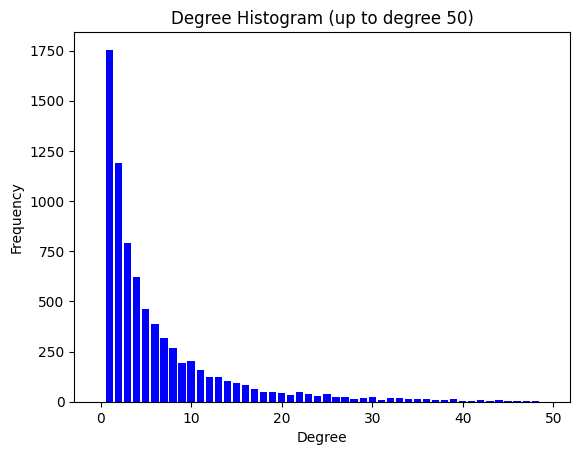

In [17]:
#plotting the distribution of the node degree

degree_freq = nx.degree_histogram(G)

max_degree = min(50, len(degree_freq))

# Plot the degree histogram for degrees up to 50
plt.bar(range(max_degree), degree_freq[:max_degree], width=0.8, color='b')

# Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Histogram (up to degree 50)')

# Show the plot
plt.show()

In [18]:
communities = community.asyn_fluidc(G, 18, max_iter=100, seed=42)

In [19]:
allcommunities = [c for c in communities]

for i, nodes in enumerate(allcommunities):
    print(len(nodes))

  # printing the size of the communities

473
217
288
688
319
373
509
477
145
390
931
286
476
347
289
466
503
447


In [20]:
def plot_graph(nodes, title):
    subgraph = G.subgraph(nodes)
    # Get unique target values
    unique_targets = set(G.nodes[node].get('target') for node in subgraph.nodes())
    # Generate a color map for target values
    target_colors = plt.cm.tab10.colors[:len(unique_targets)]  # Using the tab10 colormap
    target_color_map = {target: color for target, color in zip(unique_targets, target_colors)}
    # Get node colors based on 'target' attribute
    node_colors = [target_color_map.get(G.nodes[node].get('target'), 'gray') for node in subgraph.nodes()]
    nx.draw(subgraph, with_labels=True, node_color=node_colors, node_size=100)
    plt.title(title)

    # Create legend for target attribute
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=target, markersize=10, markerfacecolor=color) for target, color in target_color_map.items()]
    plt.legend(handles=legend_handles, title='Target', loc='upper left')
    plt.show()

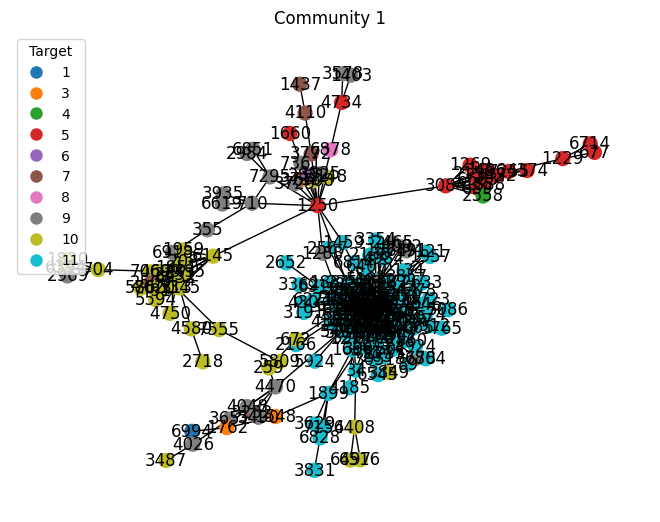

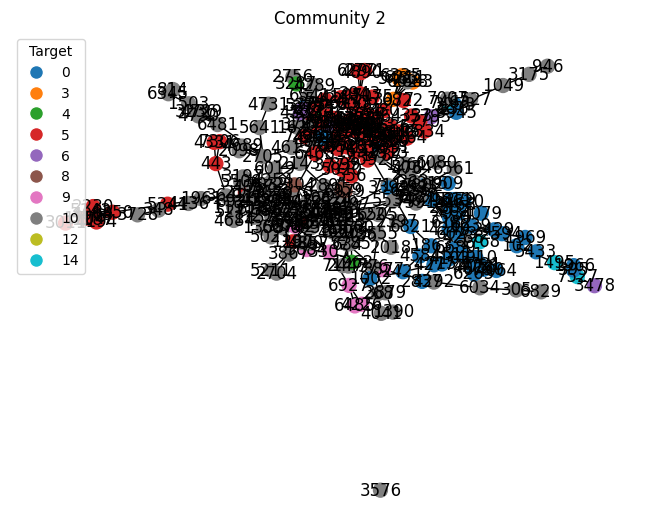

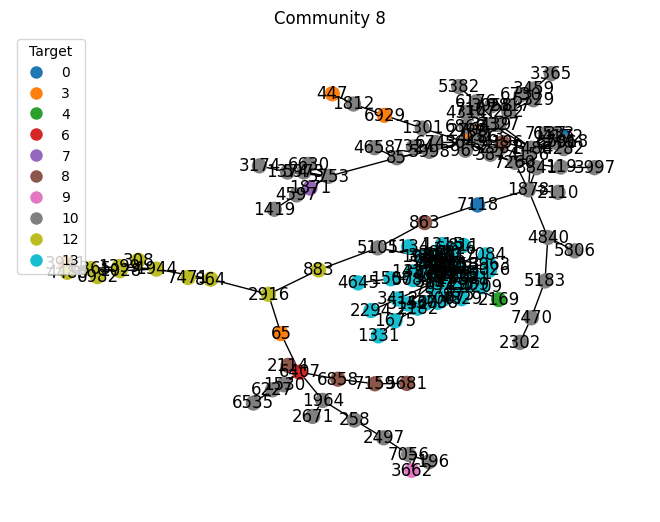

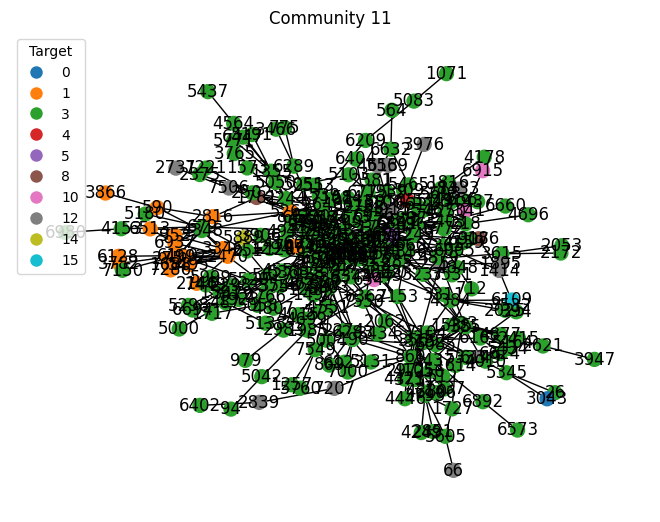

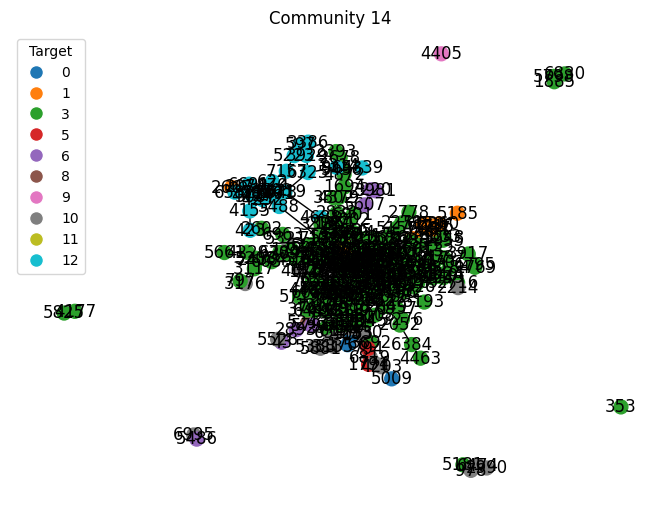

In [21]:
for i, nodes in enumerate(allcommunities):
    if len(nodes) < 300:
        plot_graph(nodes, f"Community {i}")

**We can see how similar nodes are often connected together.**

In [22]:
overall_assortativity = nx.attribute_assortativity_coefficient(G, 'target')
print("Overall Assortativity:", overall_assortativity)

# Assortativity of each community
for i, nodes in enumerate(allcommunities):
    subgraph = G.subgraph(nodes)
    community_assortativity = nx.attribute_assortativity_coefficient(subgraph, 'target')
    print(f"Assortativity of Community {i}: {community_assortativity}")

Overall Assortativity: 0.8561786926984974
Assortativity of Community 0: 0.7942975353344061
Assortativity of Community 1: 0.7895516280519882
Assortativity of Community 2: 0.8163172197647431
Assortativity of Community 3: 0.7879583965437348
Assortativity of Community 4: 0.598092123194331
Assortativity of Community 5: 0.7615131519194743
Assortativity of Community 6: 0.6188868726135008
Assortativity of Community 7: 0.5772810923663814
Assortativity of Community 8: 0.804399421128799
Assortativity of Community 9: 0.8751554902182519
Assortativity of Community 10: 0.17765685685685756
Assortativity of Community 11: 0.5880991441252403
Assortativity of Community 12: 0.7968913689521733
Assortativity of Community 13: 0.6166475898410505
Assortativity of Community 14: 0.6578785055314229
Assortativity of Community 15: 0.458978889612201
Assortativity of Community 16: 0.7797377830750899
Assortativity of Community 17: 0.38231780664549475


**Assortativity is quite high. So it its fair to say that this network has homophily (birds of a feather, flock together). Features relating to neighbour classes will therefore be helpful**

 ## Section 3. Preprocessing - Test train splits <a class="anchor" name = "chapter3" id="chapter3"></a>

Problem with random splits = if you take out random values, the 2 networks it creates can be very different from the original netowrk. You want similarly distributed but unlinked subgraphs. With the same level of dyadicity from the perspective of each node class. Ideally you'd train the model on one netowrk and evaluate it on another indepdendent network.

In [23]:
# Creating a hypothetical test_train_split algorithm which randomly selects nodes and their neighbours
# THIS IS AN OLD, INCOMPLETE CONCEPT TO GENERATE A TEST TRAIN SPLIT FOR GRAPH DATA

def graph_train_test_split(nodes, test_size, random_state = 42):

    test_set_size = len(nodes) * test_size

    random.seed(random_state)
    rand_order_nodes = nodes[:]  # Create a copy of nodes
    random.shuffle(rand_order_nodes)

    test_node_set = set()

    for node in rand_order_nodes:

        if len(test_node_set) < test_set_size:

            neigh = list(G.neighbors(node))

            test_node_set.update(neigh)

            test_node_set.update([node])

        else:
            break

    train_node_set = set(nodes) - test_node_set

    test_node_set = sorted(list(test_node_set))
    train_node_set = sorted(list(train_node_set))

    test_targets = [G.nodes[node]['target'] for node in test_node_set]

    train_targets = [G.nodes[node]['target'] for node in train_node_set]

    return train_node_set, test_node_set, train_targets, test_targets


In [24]:
nodes = list(G.nodes())
targets = [G.nodes[node]['target'] for node in nodes]

In [25]:
#Stratified test/train split

nodes_train_val, nodes_test, targets_train_val, targets_test = train_test_split(
    nodes, targets, test_size=0.2, random_state=42, stratify = targets)

nodes_train, nodes_val, targets_train, targets_val = train_test_split(
    nodes_train_val, targets_train_val, test_size=0.1, random_state=42, stratify = targets_train_val)

In [26]:
print(f"""Number of nodes

train nodes: {len(nodes_train)}
test nodes: {len(nodes_test)}
val nodes: {len(nodes_val)}
""" )

Number of nodes

train nodes: 5489
test nodes: 1525
val nodes: 610



In [27]:
#Create separate graphs for train, validation, and test sets
graph_train = G.subgraph(nodes_train)
graph_val = G.subgraph(nodes_val)
graph_test = G.subgraph(nodes_test)

 ## Section 4. Preprocessing <a class="anchor" name = "chapter4"  id="chapter4"></a>

In [28]:
list(graph_train.nodes)[0:5]

[0, 2, 3, 4, 5]

In [29]:
pip install decorator == 5.0.9

ERROR: Invalid requirement: '=='


In [30]:
len(G.nodes)

7624

In [31]:
#bet_cen = nx.degree_centrality(g)

Creating X and y would be easier using linear algebra

One cool trick is to multiply the matrix by itself and you get the 2nd order neighbour adjacency matrix

### Creating X and y. The generation of dataframes for the Xtest, ytest, Xtrain ytrain etc.

This is a particularly long process, as there are lots of features being created for X. These features involve inspecting the attributes of 2nd degree neighbour vertices so it takes a while to run.

In [32]:
# I would typically use matrix multiplcation for this task using list(G.nodes(data=True)
# But using df explode (expanding the music column to create one column for each value in the list of music thats in the music column) caused RAM issues so I'm creating the training set the long way by iterating over the graph object

def createX_y(nodeset, neigh_nodes_consider):

    X = []
    y = []

    # Iterate through each node in the graph
    for node in G.nodes():

        if node in nodeset:
            # Extract features from node attributes
            artists = G.nodes[node]['music']
            country = G.nodes[node]['target']

            # Counting number of artists a user listens to and creating a feature out of it
            num_artists = len(set(artists))

            # Extracting centrality feature
            degree_centrality = nx.degree_centrality(G)[node]


            # turning features into a useful (for dataframe) dictionary format
            features = {'degree_centrality': degree_centrality}

            # Identifying the country percentages for the  neighbors
            neighbor_countries = [G.nodes[neighbor]['target'] for neighbor in G.neighbors(node) if neighbor in neigh_nodes_consider]
            if neighbor_countries:
                total_neighbors = len(neighbor_countries)
                country_perc = {country: neighbor_countries.count(country) / total_neighbors for country in set(neighbor_countries)}
                for neigh_country, percentage in country_perc.items():
                    feature_name = f"neighbor_{neigh_country}_perc"
                    features[feature_name] = percentage


            # Identifying the country distribution among 2nd degree neighbors
            second_degree_neighbors = set()
            for neighbor in G.neighbors(node):
                if neighbor in neigh_nodes_consider:
                    second_degree_neighbors.update(G.neighbors(neighbor))
            second_degree_neighbor_countries = [G.nodes[neighbor]['target'] for neighbor in second_degree_neighbors]
            if second_degree_neighbor_countries:
                total_second_degree_neighbors = len(second_degree_neighbor_countries)
                second_degree_country_distribution = {country: second_degree_neighbor_countries.count(country) / total_second_degree_neighbors for country in set(second_degree_neighbor_countries)}
                for neigh_country, percentage in second_degree_country_distribution.items():
                    feature_name = f"second_degree_neighbor_{neigh_country}_percentage"
                    features[feature_name] = percentage


            # Adding a feature of the most common artists of nodes causes overfitting so I am not doing that here

            for artist in artists:
                features[artist] = 1
            X.append(features)

            # Append the label of the node, e.g., whether the user is from a certain country
            y.append(country)

    # Create DataFrame from features and labels
    X = pd.DataFrame(X)
    X['target'] = y

    return X, y

In [33]:
Xval, yval = createX_y(nodes_val, nodes_train)
Xtest, ytest = createX_y(nodes_test, nodes_train)
Xtrain, ytrain = createX_y(nodes_train, nodes_train)

In [34]:
Xtrain.head()

,degree_centrality,neighbor_8_perc,second_degree_neighbor_8_percentage,2964,3900,3902,2402,6185,509,7627,...,4207,7721,7629,7524,5473,269,650,794,neighbor_9_perc,target
0,0.000131,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,0.000918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,0.002361,NaN,0.007407,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
3,0.000131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,0.000131,NaN,0.222222,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17


In [35]:
print(f"""Shapes are:

validation set: X: {Xval.shape}, y: {len(yval)}

test set: X: {Xtest.shape}, y: {len(ytest)}

train set: X: {Xtrain.shape}, y: {len(ytrain)}""")

Shapes are:

validation set: X: (610, 7879), y: 610

test set: X: (1525, 7880), y: 1525

train set: X: (5489, 7880), y: 5489


In [36]:
Xval.drop('target', axis = 1, inplace = True)
Xtest.drop('target', axis = 1, inplace = True)
Xtrain.drop('target', axis = 1, inplace = True) #dropping label variable to stop accidental target leakage

In [37]:
Xval = Xval.fillna(0)
Xtest = Xtest.fillna(0)
Xtrain = Xtrain.fillna(0) # filling NAs

In [38]:
print(f"train set: X: {Xtrain.shape}, y: {len(ytrain)}")

train set: X: (5489, 7879), y: 5489


In [39]:
Xtrain.head()

,degree_centrality,neighbor_8_perc,second_degree_neighbor_8_percentage,2964,3900,3902,2402,6185,509,7627,...,3606,4207,7721,7629,7524,5473,269,650,794,neighbor_9_perc
0,0.000131,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000918,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002361,0.0,0.007407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000131,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000131,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
Xval= Xval.rename(str,axis="columns")
Xtest =Xtest.rename(str,axis="columns")
Xtrain = Xtrain.rename(str,axis="columns") # setting columns to string format as they cannot be used as numeric

In [41]:
print(f"train set: X: {Xtrain.shape}, y: {len(ytrain)}")

train set: X: (5489, 7879), y: 5489


In [42]:
#Give Xval, Xtest and Xtrain all of the columns

allcols = set(Xval.columns).union(Xtest.columns).union(Xtrain.columns)

In [43]:
for df in [Xval, Xtest, Xtrain]:
    missing_cols = allcols - set(df.columns)
    for col in missing_cols:
        df[col] = 0 #giving the X dataframes the same columns

In [44]:
Xval = Xval.reindex(columns=Xtrain.columns, fill_value=0)
Xtest = Xtest.reindex(columns=Xtrain.columns, fill_value=0) #giving the X dataframes the same columns again, the previous cell doesn't always work

 ## Section 5: Creating a Baseline Model <a class="anchor" name = "chapter5"  id="chapter5"></a>

In [45]:
def createbaselinepredict(nodeset, neigh_nodes_consider):

    X = []
    y = []

    # Iterate through each node in the graph
    for node in G.nodes():

        if node in nodeset:
            country = G.nodes[node]['target']
            # Identifying the most common country of neighbours
            neighbor_countries = [G.nodes[neighbor]['target'] for neighbor in G.neighbors(node) if neighbor in neigh_nodes_consider] # the if condition at the end esnures that there is no data leakage (test/validation set nodes being used to inform training of the model).
            common_neighbor_country = max(set(neighbor_countries), key=neighbor_countries.count) if neighbor_countries else None

            if common_neighbor_country:
                prediction = {'country_pred': common_neighbor_country}
            else:
                prediction = {'country_pred': 17} # classifying to the most common country if no neighbours available.

            X.append(prediction)

            # Append the label of the node, e.g., whether the user is from a certain country
            y.append(country)

# Create DataFrame from features and labels
    preddf = pd.DataFrame(X)
    preddf['target'] = y

    return preddf

In [46]:
Xvalbase = createbaselinepredict(nodes_val, nodes_train)

In [47]:
Xtestbase = createbaselinepredict(nodes_test, nodes_train)

In [48]:
Xvalbase

,country_pred,target
0,17,17
1,14,14
2,10,10
3,11,11
4,8,8
...,...,...
605,17,0
606,17,17
607,14,14
608,17,17


In [49]:
Xtestbase

,country_pred,target
0,17,17
1,3,3
2,17,0
3,10,10
4,17,17
...,...,...
1520,17,17
1521,17,0
1522,17,17
1523,10,10


In [50]:
accuracy_val = accuracy_score(Xvalbase['target'], Xvalbase['country_pred'])
print("Accuracy on validation set:", accuracy_val)

Accuracy on validation set: 0.7098360655737705


In [51]:
accuracy_val = accuracy_score(Xtestbase['target'], Xtestbase['country_pred'])
print("Accuracy on test set:", accuracy_val)

Accuracy on test set: 0.7068852459016394


### Baseline performance metrics:

Accuracy between 0.707 - 0.710

 ## Section 6: Model Building <a class="anchor" name = "chapter6" id="chapter6"></a>

In [87]:
# Another unused and incomplete function I worked on. A more advanced k-fold cross validation alogrithm for graphs.

def CustomKfoldCV(nodes, model, folds):

    foldlen = len(nodes) / folds

    sumaccuracy = 0
    foldlower = 0
    foldupper = 0

    for fold in range(folds):

        if fold == folds - 1:
            foldupper = len(nodes) + 1

        else:
            foldupper += foldlen

        Vnodes = list(nodes)[int(foldlower):int(foldupper)]
        nonVnodes = set(nodes) - set(Vnodes)

        print(f"fold {fold}. Using node index {foldlower} to {foldupper}")

        XnonV, ynonV = createX_y(nonVnodes, nonVnodes)

        print(f"created the non-validation sets XnonV and ynonV")

        XV, yV = createX_y(Vnodes, nonVnodes) # using nonVnodes as you don't want the validation set to know anything about the validation set labels

        print(f"created the validation sets XV and yV")


        allcols = set(XV.columns).union(XnonV.columns)
        for df in [XV, XnonV]:
            missing_cols = allcols - set(df.columns)
            for col in missing_cols:
                df[col] = 0 #giving the X dataframes the same columns
        XV = XV.reindex(columns=XnonV.columns, fill_value=0) #giving the X dataframes the same columns again, the previous cell doesn't always work

        model.fit(XnonV, ynonV)
        print(f"fitted the model")
        predictV = model.predict(XV)
        accuracy_val = accuracy_score(yV, predictV)
        print(f"fold accuracy: {accuracy_val}")
        sumaccuracy += accuracy_val
        foldlower = foldupper




    accuracy = sumaccuracy / folds

    print(f"accuracy of {accuracy}")

    return (accuracy)



In [54]:
params = {
    'reg_alpha': [0], # it seems to always perform best with no regulation parameter
    'num_leaves' : [25, 30, 35],
    #'feature_fraction': [0.75, 0.7, 0.65], #
    'feature_fraction': [0.65, 0.7, 0.75], #
    'learning_rate': [0.13, 0.1, 0.07]
}

find_optimal = False

if find_optimal:
    for alpha, frac, leaves, lr in product(params['reg_alpha'], params['feature_fraction'], params['num_leaves'], params['learning_rate']):
        lgb = LGBMClassifier(reg_alpha=alpha,
                             feature_fraction=frac,
                             num_leaves = leaves,
                             learning_rate=lr,
                             verbose=-1)
        lgb.fit(Xtrain, ytrain)
        predictions_val = lgb.predict(Xval)
        accuracy_val = accuracy_score(yval, predictions_val)
        print(f"reg_alpha: {alpha} feature_fraction: {frac} num_leaves: {leaves} learning_rate: {lr} Accuracy: {accuracy_val}")


In [55]:
# fully default params

lgb = LGBMClassifier(verbose=-1)
lgb.fit(Xtrain, ytrain)
defaultpredictions_test = lgb.predict(Xtest)
defaultaccuracy_test = accuracy_score(ytest, defaultpredictions_test)
print(f"accuracy on a fully defauly LGB model: {defaultaccuracy_test}")


accuracy on a fully defauly LGB model: 0.2301639344262295


In [56]:
lgb = LGBMClassifier(reg_alpha = 0, num_leaves = 30, feature_fraction = 0.7, learning_rate = 0.1, verbose=-1)
lgb.fit(Xtrain, ytrain)
predictions_test = lgb.predict(Xtest)
accuracy_test = accuracy_score(ytest, predictions_test)

predictions_val = lgb.predict(Xval)
accuracy_val = accuracy_score(yval, predictions_val)
print(f"test set accuracy: {accuracy_test}, validation set accuracy: {accuracy_val}")


test set accuracy: 0.8845901639344262, validation set accuracy: 0.8885245901639345


- lgb model. reg_alpha: 0 feature_fraction: 0.7 Val Accuracy: 0.8934426229508
- random forest model. Val Accuracy: 0.835

In [57]:
del G #conserving ram

 ## Section 7: Error/Performance Anaylsis <a class="anchor" name = "chapter7" id="chapter7"></a>

In [58]:
report = classification_report(ytest, predictions_test)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       220
           1       0.90      0.82      0.86        11
           2       1.00      0.73      0.85        15
           3       0.87      0.91      0.89       103
           4       0.30      1.00      0.46         3
           5       0.81      0.83      0.82        78
           6       0.88      0.86      0.87       131
           7       0.86      0.75      0.80        16
           8       0.90      0.84      0.87        94
           9       0.88      0.64      0.74        11
          10       0.91      0.95      0.93       261
          11       1.00      0.86      0.92        28
          12       1.00      0.27      0.43        11
          13       1.00      0.85      0.92        13
          14       0.90      0.79      0.84       114
          15       1.00      0.90      0.95        51
          16       0.87      0.67      0.76        51
          17       0.85    

In [59]:
report = classification_report(yval, predictions_val)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        88
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         6
           3       0.93      0.95      0.94        41
           4       0.33      1.00      0.50         1
           5       0.96      0.81      0.88        31
           6       0.78      0.83      0.80        52
           7       0.83      0.71      0.77         7
           8       0.97      0.84      0.90        37
           9       1.00      0.80      0.89         5
          10       0.87      0.92      0.90       104
          11       1.00      0.82      0.90        11
          12       1.00      0.80      0.89         5
          13       1.00      1.00      1.00         5
          14       0.97      0.78      0.87        46
          15       1.00      0.95      0.98        21
          16       0.81      0.65      0.72        20
          17       0.83    

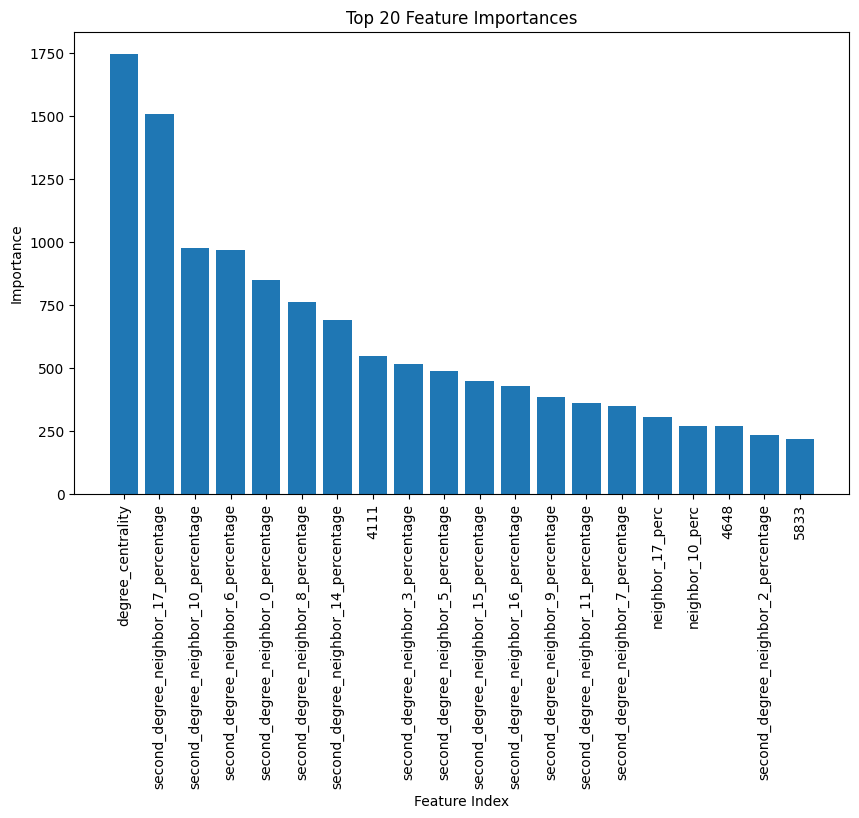

In [60]:
importances = lgb.feature_importances_

sorted_indices = np.argsort(importances)[::-1] # feature importances ordered by importance

plot_num_features = 20

# Plot top N feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(plot_num_features), importances[sorted_indices[:plot_num_features]], align="center")
plt.xticks(range(plot_num_features), [Xtrain.columns[i] for i in sorted_indices[:plot_num_features]], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [61]:
# all feature importances
print("Features by importance:")
for i, idx in enumerate(sorted_indices[0:40]):
    print(f"{i+1}. Feature {Xtrain.columns[idx]}: {importances[idx]}")

Features by importance:
1. Feature degree_centrality: 1748
2. Feature second_degree_neighbor_17_percentage: 1510
3. Feature second_degree_neighbor_10_percentage: 977
4. Feature second_degree_neighbor_6_percentage: 969
5. Feature second_degree_neighbor_0_percentage: 851
6. Feature second_degree_neighbor_8_percentage: 762
7. Feature second_degree_neighbor_14_percentage: 689
8. Feature 4111: 548
9. Feature second_degree_neighbor_3_percentage: 514
10. Feature second_degree_neighbor_5_percentage: 486
11. Feature second_degree_neighbor_15_percentage: 446
12. Feature second_degree_neighbor_16_percentage: 429
13. Feature second_degree_neighbor_9_percentage: 384
14. Feature second_degree_neighbor_11_percentage: 362
15. Feature second_degree_neighbor_7_percentage: 348
16. Feature neighbor_17_perc: 304
17. Feature neighbor_10_perc: 268
18. Feature 4648: 268
19. Feature second_degree_neighbor_2_percentage: 233
20. Feature 5833: 216
21. Feature second_degree_neighbor_12_percentage: 203
22. Feature 

 ## Section 8: Feature Selection (Custom backward stepwise algo) <a class="anchor" name = "chapter8" id="chapter8"></a>

In [62]:
def results_on_reduced_featureset(Xtrain, Xtest, Xval, weakest_feat_num): # a basic function to create a model and output the scores along with the 50 least important features
    lgb = LGBMClassifier(reg_alpha = 0, feature_fraction = 0.7, verbose=-1)
    lgb.fit(Xtrain, ytrain)
    predictions_test = lgb.predict(Xtest)
    accuracy_test = accuracy_score(ytest, predictions_test)
    predictions_val = lgb.predict(Xval)
    accuracy_val = accuracy_score(yval, predictions_val)
    importances = lgb.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    weakest_feats = sorted_indices[-weakest_feat_num:]
    return(accuracy_test, accuracy_val, weakest_feats)

In [63]:
indices_to_drop = sorted_indices[-50:]

Xtrain_filtered = Xtrain.drop(Xtrain.columns[indices_to_drop], axis=1)
Xtest_filtered = Xtest.drop(Xtest.columns[indices_to_drop], axis=1)
Xval_filtered = Xval.drop(Xval.columns[indices_to_drop], axis=1) # seting up the _filtered dataframes

Dropping 6800 features.

Given I have ~5500 observations, ~1100 features sounds reasonable.

Rule of thumb for number of features vs number of observations. Some people say 5x observations. Or others say N-1 (if features are uncorrelated) or sqrt (N) if correlated. I found some (~0.35) correlation between features.

In [64]:
weakest_feat_num =  400
loops = 13

for reduction in range(loops):

    accuracy_test, accuracy_val, weakest_feats = results_on_reduced_featureset(Xtrain_filtered, Xtest_filtered, Xval_filtered, weakest_feat_num) # getting accuracy scores and the weakest 50 features of the reduced dataset

    Xtrain_filtered = Xtrain_filtered.drop(Xtrain_filtered.columns[weakest_feats], axis=1) # dropping the 50 weakest features of the latest iteration
    Xtest_filtered = Xtest_filtered.drop(Xtest_filtered.columns[weakest_feats], axis=1)
    Xval_filtered = Xval_filtered.drop(Xval_filtered.columns[weakest_feats], axis=1)

    print(f"test set accuracy: {accuracy_test}, validation set accuracy: {accuracy_val}, num features dropped: {weakest_feat_num + ((reduction)*weakest_feat_num)}") # printing results


test set accuracy: 0.8865573770491804, validation set accuracy: 0.8852459016393442, num features dropped: 400
test set accuracy: 0.8845901639344262, validation set accuracy: 0.8885245901639345, num features dropped: 800
test set accuracy: 0.8839344262295082, validation set accuracy: 0.8901639344262295, num features dropped: 1200
test set accuracy: 0.8845901639344262, validation set accuracy: 0.8852459016393442, num features dropped: 1600
test set accuracy: 0.8891803278688525, validation set accuracy: 0.8934426229508197, num features dropped: 2000
test set accuracy: 0.8878688524590164, validation set accuracy: 0.8885245901639345, num features dropped: 2400
test set accuracy: 0.8832786885245901, validation set accuracy: 0.8852459016393442, num features dropped: 2800
test set accuracy: 0.8872131147540984, validation set accuracy: 0.8885245901639345, num features dropped: 3200
test set accuracy: 0.8904918032786885, validation set accuracy: 0.8852459016393442, num features dropped: 3600
tes

In [65]:
Xtrain_filtered.shape

(5489, 2629)

In [66]:
Xtrain.shape

(5489, 7879)

 ## Section 9: Final Model <a class="anchor" name = "chapter9" id="chapter9"></a>

In [67]:
params = {
    'reg_alpha': [0], # it seems to always perform best with no regulation parameter
    'num_leaves' : [25, 30, 35],
    #'feature_fraction': [0.75, 0.7, 0.65], #
    'feature_fraction': [0.65, 0.7, 0.75], #
    'learning_rate': [0.13, 0.1, 0.07]
}

find_optimal = False

if find_optimal:
    for alpha, frac, leaves, lr in product(params['reg_alpha'], params['feature_fraction'], params['num_leaves'], params['learning_rate']):
        lgb = LGBMClassifier(reg_alpha=alpha,
                             feature_fraction=frac,
                             num_leaves = leaves,
                             learning_rate=lr,
                             verbose=-1)
        lgb.fit(Xtrain_filtered, ytrain)
        predictions_val = lgb.predict(Xval_filtered)
        accuracy_val = accuracy_score(yval, predictions_val)
        print(f"reg_alpha: {alpha} feature_fraction: {frac} num_leaves: {leaves} learning_rate: {lr} Accuracy: {accuracy_val}")

In [68]:
reg_alpha = 0
feature_fraction = 0.65
num_leaves = 35
learning_rate = 0.07

lgb = LGBMClassifier(reg_alpha=reg_alpha,
                     feature_fraction=feature_fraction,
                     num_leaves=num_leaves,
                     learning_rate=learning_rate,
                     verbose=-1)
lgb.fit(Xtrain_filtered, ytrain)
predictions_val = lgb.predict(Xval_filtered)
accuracy_val = accuracy_score(yval, predictions_val)
predictions_test = lgb.predict(Xtest_filtered)
accuracy_test = accuracy_score(ytest, predictions_test)

print(f"test set accuracy: {accuracy_test}, validation set accuracy: {accuracy_val}")


test set accuracy: 0.8904918032786885, validation set accuracy: 0.8934426229508197


In [69]:
predictions_val_df = pd.DataFrame(predictions_val, columns=['Predictions'])
predictions_test_df = pd.DataFrame(predictions_test, columns=['Predictions'])

# Write DataFrames to CSV files
predictions_val_df.to_csv('predictions_val.csv', index=False)
predictions_test_df.to_csv('predictions_test.csv', index=False)

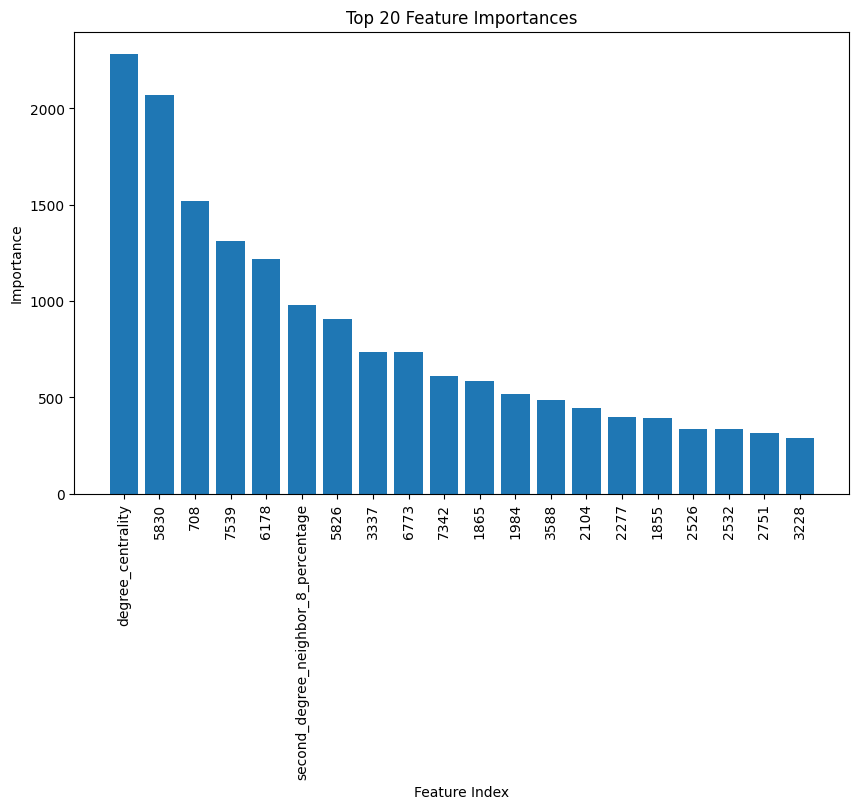

In [70]:
importances = lgb.feature_importances_

sorted_indices = np.argsort(importances)[::-1] # feature importances ordered by importance

plot_num_features = 20

# Plot top N feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(plot_num_features), importances[sorted_indices[:plot_num_features]], align="center")
plt.xticks(range(plot_num_features), [Xtrain.columns[i] for i in sorted_indices[:plot_num_features]], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [71]:
testreport = classification_report(ytest, predictions_test)

In [72]:
valreport = classification_report(ytest, predictions_test)

In [73]:
print(testreport)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       220
           1       0.90      0.82      0.86        11
           2       0.92      0.73      0.81        15
           3       0.87      0.91      0.89       103
           4       0.50      0.67      0.57         3
           5       0.82      0.83      0.83        78
           6       0.86      0.85      0.85       131
           7       0.86      0.75      0.80        16
           8       0.93      0.83      0.88        94
           9       1.00      0.64      0.78        11
          10       0.93      0.96      0.94       261
          11       1.00      0.86      0.92        28
          12       1.00      0.45      0.62        11
          13       1.00      0.92      0.96        13
          14       0.91      0.81      0.86       114
          15       1.00      0.88      0.94        51
          16       0.90      0.69      0.78        51
          17       0.84    

In [74]:
# Assuming you have the classification reports already generated for validation and test sets
valreport = classification_report(yval, predictions_val)
testreport = classification_report(ytest, predictions_test)

# Function to parse classification report
def parse_classification_report(report):
    lines = report.split('\n')
    data = []
    for line in lines[2:-5]:
        row = line.split()
        row_data = [float(row[1]), float(row[2]), float(row[3]), float(row[4])]
        data.append(row_data)
    return pd.DataFrame(data, columns=['Precision', 'Recall', 'F1-score', 'Support'])

# Convert validation and test reports to DataFrames
val_report_df = parse_classification_report(valreport)
test_report_df = parse_classification_report(testreport)


val_report_df.to_csv('val_classification_report.csv', index=True)
test_report_df.to_csv('test_classification_report.csv', index=True)


## That's it!